# 위험추종군 포트폴리오 최적화

## 동일비중


In [137]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_prop = fm.FontProperties(fname=font_path, size=12)

# 폰트 설정
plt.rc('font', family='NanumBarunGothic')

In [138]:
!pip install yfinance --quiet

In [139]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
sns.set()

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 포트폴리오 데이터 다운로드
tickers = ['007980.KS','014530.KS','038010.KS','042670.KS','014190.KQ','036090.KQ','000490.KS','377450.KQ','088350.KS','058730.KS']
ptf = yf.Tickers(tickers)
data = ptf.history(interval='1d' ,start='2022-11-15',end='2023-11-16', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1)

[*********************100%%**********************]  10 of 10 completed


In [ ]:
xrp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y-FoRM/장기프로젝트/암호화폐 자료/XRP 과거 데이터.csv')
bnb = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y-FoRM/장기프로젝트/암호화폐 자료/BNB 과거 데이터.csv')
tet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y-FoRM/장기프로젝트/암호화폐 자료/Tether 과거 데이터.csv')
ether = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y-FoRM/장기프로젝트/암호화폐 자료/이더리움 과거 데이터.csv')
bit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y-FoRM/장기프로젝트/암호화폐 자료/비트코인 과거 데이터.csv')

In [ ]:
xrp

,날짜,종가,시가,고가,저가,거래량,변동 %
0,2023-11-15,0.63726,0.62956,0.64111,0.62526,592.15M,1.25%
1,2023-11-14,0.62942,0.67046,0.67119,0.59744,760.69M,-6.11%
2,2023-11-13,0.67037,0.66130,0.74785,0.64231,944.37M,1.32%
3,2023-11-12,0.66161,0.66275,0.67076,0.64779,255.02M,-0.17%
4,2023-11-11,0.66275,0.65943,0.68500,0.64170,499.64M,0.46%
...,...,...,...,...,...,...,...
361,2022-11-19,0.38401,0.38039,0.38822,0.37989,199.13M,0.62%
362,2022-11-18,0.38166,0.38379,0.38487,0.37519,380.62M,-0.19%
363,2022-11-17,0.38239,0.37386,0.38619,0.36936,545.28M,2.36%
364,2022-11-16,0.37355,0.38900,0.39098,0.36229,471.29M,-3.99%


In [ ]:
xrp.drop(['시가', '고가', '저가', '거래량','변동 %'], inplace=True, axis=1)
xrp.sort_values(by='날짜',inplace=True)
xrp.columns = ['Date','XRP']
xrp

,Date,XRP
365,2022-11-15,0.38908
364,2022-11-16,0.37355
363,2022-11-17,0.38239
362,2022-11-18,0.38166
361,2022-11-19,0.38401
...,...,...
4,2023-11-11,0.66275
3,2023-11-12,0.66161
2,2023-11-13,0.67037
1,2023-11-14,0.62942


In [ ]:
xrp['Date']=xrp['Date'].astype('datetime64')

In [ ]:
data=data.reset_index()
data

,Date,000490.KS,007980.KS,014190.KQ,014530.KS,036090.KQ,038010.KS,042670.KS,058730.KS,088350.KS,377450.KQ
0,2022-11-15,10862.399414,1484.114380,2670.0,3553.466309,767.0,8062.185059,7414.916992,5900.0,2300.0,7930.0
1,2022-11-16,10515.200195,1611.885742,2570.0,3586.720703,768.0,7993.361328,7434.302246,6030.0,2275.0,7960.0
2,2022-11-17,10465.599609,1710.171509,2525.0,3596.221924,760.0,8003.193359,7347.067871,5740.0,2275.0,7920.0
3,2022-11-18,10267.200195,1700.342896,2380.0,3558.217041,752.0,8121.176270,7812.317383,5610.0,2240.0,7940.0
4,2022-11-21,10316.799805,1700.342896,2375.0,3510.710693,727.0,7855.714355,7443.995117,5570.0,2300.0,7900.0
...,...,...,...,...,...,...,...,...,...,...,...
248,2023-11-09,12960.000000,1783.000000,1522.0,4110.000000,920.0,7720.000000,7250.000000,4295.0,2765.0,7790.0
249,2023-11-10,12700.000000,1813.000000,1503.0,4030.000000,910.0,7630.000000,7310.000000,4285.0,2760.0,7880.0
250,2023-11-13,12590.000000,1788.000000,1500.0,4155.000000,949.0,7700.000000,7150.000000,4190.0,2785.0,7900.0
251,2023-11-14,13120.000000,1823.000000,1504.0,4180.000000,945.0,7890.000000,7230.000000,4180.0,2830.0,7950.0


In [ ]:
data=pd.merge(data,xrp)
data

,Date,000490.KS,007980.KS,014190.KQ,014530.KS,036090.KQ,038010.KS,042670.KS,058730.KS,088350.KS,377450.KQ,XRP
0,2022-11-15,10862.399414,1484.114380,2670.0,3553.466309,767.0,8062.185059,7414.916992,5900.0,2300.0,7930.0,0.38908
1,2022-11-16,10515.200195,1611.885742,2570.0,3586.720703,768.0,7993.361328,7434.302246,6030.0,2275.0,7960.0,0.37355
2,2022-11-17,10465.599609,1710.171509,2525.0,3596.221924,760.0,8003.193359,7347.067871,5740.0,2275.0,7920.0,0.38239
3,2022-11-18,10267.200195,1700.342896,2380.0,3558.217041,752.0,8121.176270,7812.317383,5610.0,2240.0,7940.0,0.38166
4,2022-11-21,10316.799805,1700.342896,2375.0,3510.710693,727.0,7855.714355,7443.995117,5570.0,2300.0,7900.0,0.36455
...,...,...,...,...,...,...,...,...,...,...,...,...
248,2023-11-09,12960.000000,1783.000000,1522.0,4110.000000,920.0,7720.000000,7250.000000,4295.0,2765.0,7790.0,0.66659
249,2023-11-10,12700.000000,1813.000000,1503.0,4030.000000,910.0,7630.000000,7310.000000,4285.0,2760.0,7880.0,0.65969
250,2023-11-13,12590.000000,1788.000000,1500.0,4155.000000,949.0,7700.000000,7150.000000,4190.0,2785.0,7900.0,0.67037
251,2023-11-14,13120.000000,1823.000000,1504.0,4180.000000,945.0,7890.000000,7230.000000,4180.0,2830.0,7950.0,0.62942


In [ ]:
data.set_index('Date',inplace=True)
data

,000490.KS,007980.KS,014190.KQ,014530.KS,036090.KQ,038010.KS,042670.KS,058730.KS,088350.KS,377450.KQ,XRP
Date,,,,,,,,,,,
2022-11-15,10862.399414,1484.114380,2670.0,3553.466309,767.0,8062.185059,7414.916992,5900.0,2300.0,7930.0,0.38908
2022-11-16,10515.200195,1611.885742,2570.0,3586.720703,768.0,7993.361328,7434.302246,6030.0,2275.0,7960.0,0.37355
2022-11-17,10465.599609,1710.171509,2525.0,3596.221924,760.0,8003.193359,7347.067871,5740.0,2275.0,7920.0,0.38239
2022-11-18,10267.200195,1700.342896,2380.0,3558.217041,752.0,8121.176270,7812.317383,5610.0,2240.0,7940.0,0.38166
2022-11-21,10316.799805,1700.342896,2375.0,3510.710693,727.0,7855.714355,7443.995117,5570.0,2300.0,7900.0,0.36455
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,12960.000000,1783.000000,1522.0,4110.000000,920.0,7720.000000,7250.000000,4295.0,2765.0,7790.0,0.66659
2023-11-10,12700.000000,1813.000000,1503.0,4030.000000,910.0,7630.000000,7310.000000,4285.0,2760.0,7880.0,0.65969
2023-11-13,12590.000000,1788.000000,1500.0,4155.000000,949.0,7700.000000,7150.000000,4190.0,2785.0,7900.0,0.67037


In [ ]:
# 수익률 계산
rets = data.pct_change().fillna(0)
rets

,000490.KS,007980.KS,014190.KQ,014530.KS,036090.KQ,038010.KS,042670.KS,058730.KS,088350.KS,377450.KQ,XRP
Date,,,,,,,,,,,
2022-11-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-11-16,-0.031963,0.086093,-0.037453,0.009358,0.001304,-0.008537,0.002614,0.022034,-0.010870,0.003783,-0.039915
2022-11-17,-0.004717,0.060976,-0.017510,0.002649,-0.010417,0.001230,-0.011734,-0.048093,0.000000,-0.005025,0.023665
2022-11-18,-0.018957,-0.005747,-0.057426,-0.010568,-0.010526,0.014742,0.063325,-0.022648,-0.015385,0.002525,-0.001909
2022-11-21,0.004831,0.000000,-0.002101,-0.013351,-0.033245,-0.032688,-0.047146,-0.007130,0.026786,-0.005038,-0.044830
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,-0.011442,-0.008894,-0.000657,-0.007246,0.244926,0.009150,-0.004121,-0.001163,0.016544,-0.011421,-0.029892
2023-11-10,-0.020062,0.016826,-0.012484,-0.019465,-0.010870,-0.011658,0.008276,-0.002328,-0.001808,0.011553,-0.010351
2023-11-13,-0.008661,-0.013789,-0.001996,0.031017,0.042857,0.009174,-0.021888,-0.022170,0.009058,0.002538,0.016189


In [ ]:
# 가중치 계산 함수
def get_ew_weights(rets):
    noa = len(rets.columns)
    weights = np.ones_like(rets) * (1/noa)
    return weights

# 동일 가중치
weights = get_ew_weights(rets)[-1]

In [ ]:
weights

array([0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909])

In [ ]:
# 색깔 팔레트
pal = sns.color_palette('Spectral', len(tickers))

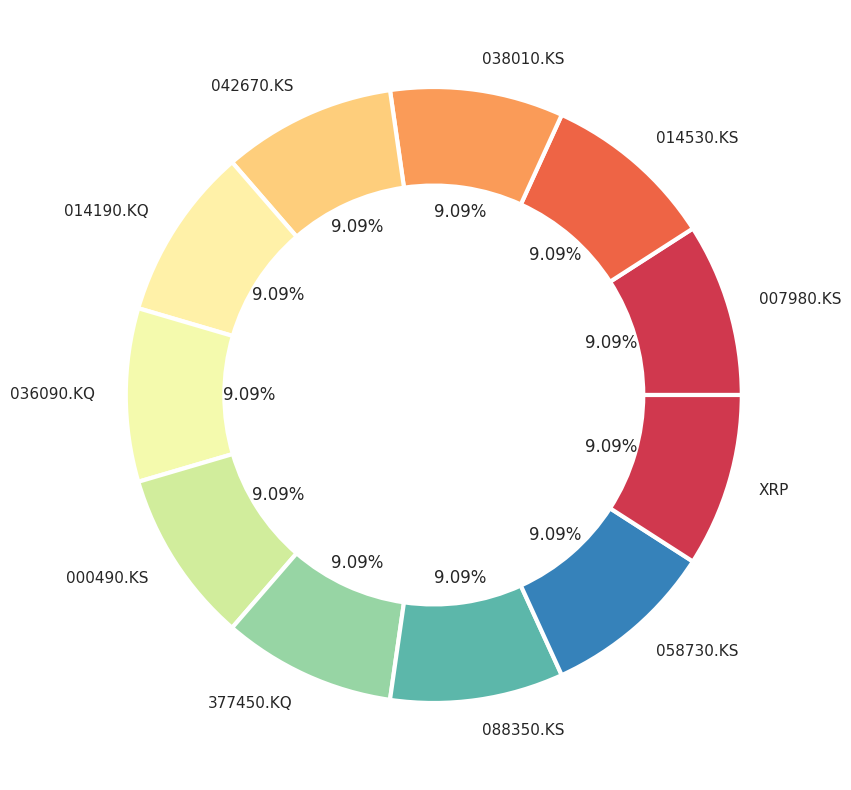

In [ ]:
tickers.append('XRP')

# 파이차트 시각화
plt.figure(figsize=(10, 10))
wedgeprops = {'width': 0.32, 'edgecolor': 'w', 'linewidth': 3}
plt.pie(weights, labels=tickers, autopct='%.2f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

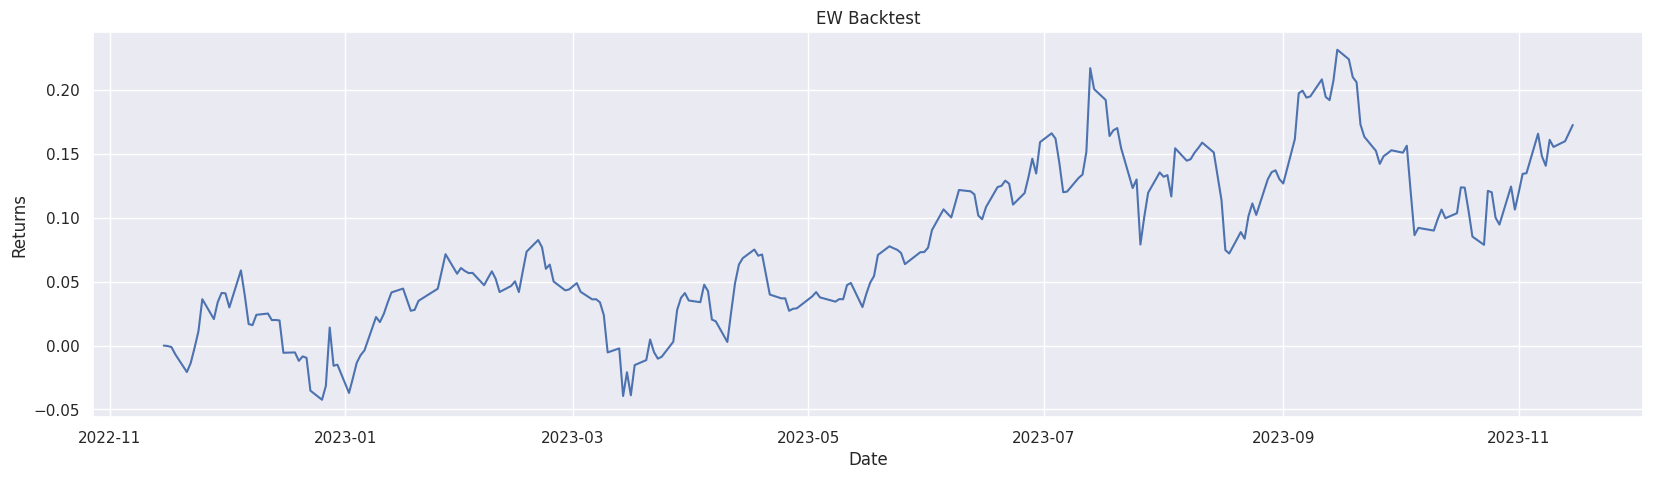

In [ ]:
# 시계열 가중치 데이터프레임
ew_w_df = pd.DataFrame(get_ew_weights(rets), index=rets.index, columns=rets.columns)

# 동일 비중 포트폴리오 수익률
ew_port_rets = ew_w_df.shift() * rets

# 포트폴리오 누적 수익률
ew_port_cum_rets = (1 + ew_port_rets.sum(axis=1)).cumprod() - 1

# 그래프 결과
plt.figure(figsize=(20, 5))
plt.plot(ew_port_cum_rets)
plt.title('EW Backtest')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

## 샤프비율 최대화

In [ ]:
# 초기값 설정
noa = rets.shape[1]  # noa는 주어진 데이터(rets)의 열의 수를 나타냅니다. 이는 투자 대상 자산의 수입니다.
init_guess = np.repeat(1/noa, noa)  # init_guess는 초기 가중치를 동일하게 설정합니다. 각 자산에 동일한 비율로 투자합니다.

# 기대수익률 벡터
er = rets.mean() * 12  # er는 각 자산의 연간 기대수익률을 계산합니다.

# 공분산행렬
cov = rets.cov() * 12  # cov는 각 자산 간의 연간 공분산 행렬을 계산합니다.

# 각 ETF별 투자 가중치 상하한선 : 공매도 불가 조건
bounds = ((0.0, 1.0), ) * noa  # bounds는 각 자산의 투자 가중치의 상하한을 설정합니다. 여기서는 0과 1 사이로 설정하여 공매도를 금지합니다.

# 제약조건 : 전체 가중치의 합이 1, 레버리지 불가 조건
weights_sum_to_1 = {'type': 'eq',
                    'fun': lambda weights: np.sum(weights) - 1}  # weights_sum_to_1은 투자 가중치의 합이 1이 되도록 하는 제약조건입니다.

# 목적함수 : 마이너스 샤프비율
def neg_sharpe(weights, er, cov):  # neg_sharpe는 마이너스 샤프 비율을 계산하는 함수입니다.
    r = weights.T @ er  # r은 포트폴리오의 기대수익률입니다.
    vol = np.sqrt(weights.T @ cov @ weights)  # vol은 포트폴리오의 변동성입니다.
    return - r / vol  # 샤프 비율은 기대수익률을 변동성으로 나눈 값입니다. 여기서는 최대화 문제를 최소화 문제로 바꾸기 위해 음수를 취합니다.

# 최적화 알고리즘 구동
res = minimize(neg_sharpe,  # res는 최적화 알고리즘을 실행하여 얻은 결과입니다.
               init_guess,  # 초기 가중치로 init_guess를 사용합니다.
               args=(er, cov),  # 목적함수 neg_sharpe에 전달할 추가 인자입니다.
               method='SLSQP',  # 최적화 알고리즘으로 Sequential Least Squares Programming(SLSQP)을 사용합니다.
               constraints=(weights_sum_to_1,),  # 제약조건으로 weights_sum_to_1을 사용합니다.
               bounds=bounds)  # 각 자산의 투자 가중치의 상하한으로 bounds를 사용합니다.

# 가중치 결과값
weights = res.x  # weights는 최적화된 투자 가중치입니다.

# 결과 출력
print(weights)  # 최적화된 투자 가중치를 출력합니다.

[1.46600280e-01 1.25849847e-01 0.00000000e+00 1.97630508e-01
 1.12670229e-01 0.00000000e+00 3.55801141e-02 1.19004741e-16
 2.03443319e-01 0.00000000e+00 1.78225702e-01]


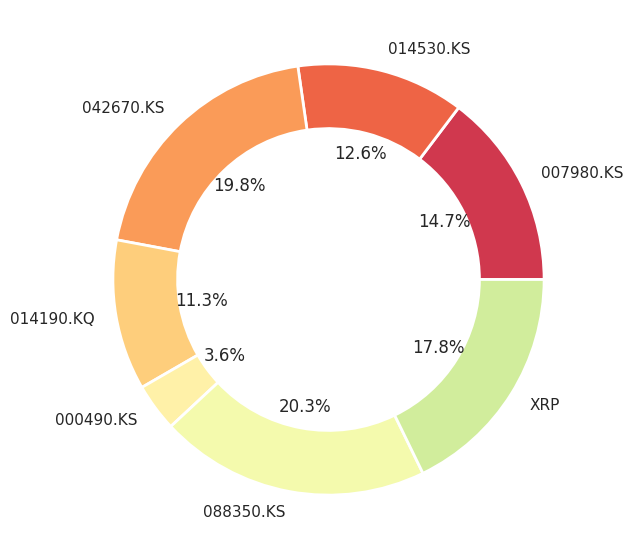

In [ ]:
# 가중치 데이터프레임 생성
weights_df = pd.Series(np.round(weights, 3), index=tickers)
weights_df = weights_df[weights_df > 0.0]

# 파이차트 시각화
plt.figure(figsize=(7, 7))
wedgeprops = {'width':0.3, 'edgecolor':'w', 'linewidth':2}
plt.pie(weights_df, labels=weights_df.index, autopct='%.1f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

In [ ]:
# MSR 모델 가중치 계산 함수
def get_msr_weights(er, cov):

    # 자산 개수
    noa = er.shape[0]

    # 초기 가중치
    init_guess = np.repeat(1/noa, noa)

    # 제약조건 및 상하한값
    bounds = ((0.0, 1.0), ) * noa
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1}

    # 목적함수: 마이너스 샤프비율
    def neg_sharpe(weights, er, cov):
        r = weights.T @ er
        vol = np.sqrt(weights.T @ cov @ weights)
        return - r / vol

    # 최적화 수행
    res = minimize(neg_sharpe,
                   init_guess,
                   args=(er, cov),
                   method='SLSQP',
                   constraints=(weights_sum_to_1,),
                   bounds=bounds)

    return res.x

In [ ]:
# 빈 데이터프레임 생성
msr_w_df = pd.DataFrame().reindex_like(rets)

# 기대수익률 배열
er = np.array(rets * 12)

# 공분산행렬 배열
cov = rets.rolling(12).cov().fillna(0) * 12
cov = cov.values.reshape(int(cov.shape[0] / cov.shape[1]), cov.shape[1], cov.shape[1])

for i in range(12, len(msr_w_df)):
    msr_w_df.iloc[i] = get_msr_weights(er[i-1], cov[i-1])

In [ ]:
msr_w_df

,000490.KS,007980.KS,014190.KQ,014530.KS,036090.KQ,038010.KS,042670.KS,058730.KS,088350.KS,377450.KQ,XRP
Date,,,,,,,,,,,
2022-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,0.000000e+00,0.000000e+00,4.628955e-01,1.216484e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,4.946011e-01,4.250333e-02
2023-11-10,1.632167e-15,5.997327e-17,0.000000e+00,1.829517e-01,4.425175e-01,0.000000e+00,3.810654e-15,7.816404e-16,0.238287,1.362435e-01,6.619125e-16
2023-11-13,3.888761e-15,9.480015e-01,0.000000e+00,0.000000e+00,2.058458e-15,1.064828e-15,5.310067e-16,2.240714e-16,0.029245,3.275439e-16,2.275306e-02


Text(0, 0.5, 'Returns')

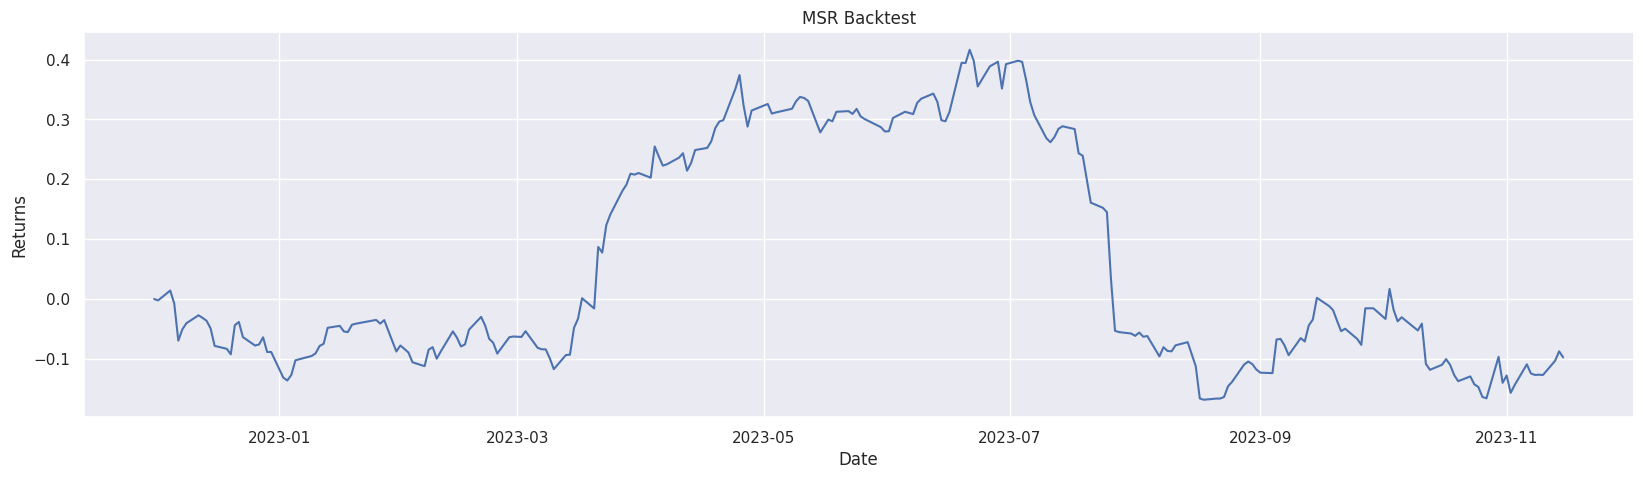

In [ ]:
# 포트폴리오 수익률 데이터프레임
msr_port_rets = msr_w_df.shift() * rets
msr_port_cum_rets = (1 + msr_port_rets.sum(axis=1)).cumprod() - 1

# MSR 백테스팅 시각화
plt.figure(figsize=(20, 5))
plt.plot(msr_port_cum_rets.iloc[12:])
plt.title('MSR Backtest')
plt.xlabel('Date')
plt.ylabel('Returns')

# 위험중립군 포트폴리오 최적화

## 동일비중

In [145]:
# 포트폴리오 데이터 다운로드
tickers = ['042700.KS','001570.KS','007660.KS','006110.KS','298040.KS','047050.KS','005070.KS','009420.KS','267260.KS','005490.KS']
ptf = yf.Tickers(tickers)
data2 = ptf.history(interval='1d' ,start='2022-11-15',end='2023-11-16', actions=False)
data2.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data2 = data2.droplevel(0, axis=1)

[*********************100%%**********************]  10 of 10 completed


In [142]:
bnb = pd.read_csv("/content/drive/MyDrive/cryptocurrency/BNB 과거 데이터.csv")
ether = pd.read_csv("/content/drive/MyDrive/cryptocurrency/ETH-USD.csv")
bit = pd.read_csv("/content/drive/MyDrive/cryptocurrency/BTC-USD.csv")

In [143]:
ether.rename(columns={'Date': '날짜', 'Close': '종가'}, inplace=True)
bit.rename(columns={'Date': '날짜', 'Close': '종가'}, inplace=True)

bnb_close = bnb[['날짜', '종가']].copy()
ether_close = ether[['날짜', '종가']].copy()
bit_close = bit[['날짜', '종가']].copy()

ether_close = ether_close.sort_values(by='날짜', ascending=False)
bit_close = bit_close.sort_values(by='날짜', ascending=False)

ether_close['날짜'] = pd.to_datetime(ether_close['날짜']).dt.strftime('%Y- %m- %d')
bit_close['날짜'] = pd.to_datetime(bit_close['날짜']).dt.strftime('%Y- %m- %d')

merged_df = pd.merge(bnb_close, ether_close, on='날짜', how='outer')
merged_df = pd.merge(merged_df, bit_close, on='날짜', how='outer')

# 컬럼 이름 변경
merged_df.columns = ['Date', 'bnb', 'ether', 'bit']

# 결과 확인
merged_df.head(10)

,Date,bnb,ether,bit
0,2023- 11- 15,251.10,2060.408447,37880.582031
1,2023- 11- 14,242.20,1979.052612,35537.640625
2,2023- 11- 13,241.19,2055.265381,36502.355469
3,2023- 11- 12,247.40,2045.187012,37054.519531
4,2023- 11- 11,251.59,2052.713867,37138.050781
5,2023- 11- 10,250.90,2078.289795,37313.968750
6,2023- 11- 09,251.70,2120.561035,36693.125000
7,2023- 11- 08,246.71,1889.322388,35655.277344
8,2023- 11- 07,246.30,1888.124268,35443.562500
9,2023- 11- 06,255.09,1899.837402,35037.371094


In [144]:
merged_df.sort_values(by='Date',inplace=True)
merged_df
merged_df['Date']=merged_df['Date'].astype('datetime64')

In [146]:
data2=data2.reset_index()

In [147]:
data2=pd.merge(data2,merged_df)
data2

,Date,001570.KS,005070.KS,005490.KS,006110.KS,007660.KS,009420.KS,042700.KS,047050.KS,267260.KS,298040.KS,bnb,ether,bit
0,2022-11-15,30000.0,64000.0,287380.96875,32038.939453,6213.243164,15000.0,12836.938477,21583.501953,40323.363281,72200.0,277.00,1251.736206,NaN
1,2022-11-16,31350.0,63400.0,283930.43750,32535.666016,6154.256836,14750.0,12935.305664,22015.171875,41311.679688,73400.0,270.20,1215.602539,NaN
2,2022-11-17,31500.0,60600.0,279986.96875,31989.265625,6134.594727,15050.0,12689.387695,21391.648438,40817.523438,73000.0,268.50,1200.808594,NaN
3,2022-11-18,30900.0,60800.0,285409.21875,31194.501953,5957.635254,15200.0,12787.754883,21103.869141,40916.355469,73500.0,273.00,1212.300293,NaN
4,2022-11-21,32700.0,59100.0,284423.34375,30648.101562,5800.337891,14850.0,12886.122070,21055.906250,40026.867188,77000.0,254.10,1108.353027,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2023-11-09,102700.0,155400.0,460500.00000,125800.000000,26000.000000,35000.0,61500.000000,59100.000000,82100.000000,185000.0,251.70,2120.561035,36693.125000
244,2023-11-10,100400.0,150900.0,447500.00000,129200.000000,27150.000000,33600.0,66300.000000,56400.000000,83500.000000,193400.0,250.90,2078.289795,37313.968750
245,2023-11-13,99600.0,149700.0,452000.00000,123800.000000,25150.000000,34600.0,57800.000000,58100.000000,84400.000000,189800.0,241.19,2055.265381,36502.355469
246,2023-11-14,104200.0,157600.0,471500.00000,126700.000000,26900.000000,35150.0,59500.000000,59500.000000,82900.000000,190000.0,242.20,1979.052612,35537.640625


In [149]:
data2.set_index('Date',inplace=True)
data2

,001570.KS,005070.KS,005490.KS,006110.KS,007660.KS,009420.KS,042700.KS,047050.KS,267260.KS,298040.KS,bnb,ether,bit
Date,,,,,,,,,,,,,
2022-11-15,30000.0,64000.0,287380.96875,32038.939453,6213.243164,15000.0,12836.938477,21583.501953,40323.363281,72200.0,277.00,1251.736206,NaN
2022-11-16,31350.0,63400.0,283930.43750,32535.666016,6154.256836,14750.0,12935.305664,22015.171875,41311.679688,73400.0,270.20,1215.602539,NaN
2022-11-17,31500.0,60600.0,279986.96875,31989.265625,6134.594727,15050.0,12689.387695,21391.648438,40817.523438,73000.0,268.50,1200.808594,NaN
2022-11-18,30900.0,60800.0,285409.21875,31194.501953,5957.635254,15200.0,12787.754883,21103.869141,40916.355469,73500.0,273.00,1212.300293,NaN
2022-11-21,32700.0,59100.0,284423.34375,30648.101562,5800.337891,14850.0,12886.122070,21055.906250,40026.867188,77000.0,254.10,1108.353027,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,102700.0,155400.0,460500.00000,125800.000000,26000.000000,35000.0,61500.000000,59100.000000,82100.000000,185000.0,251.70,2120.561035,36693.125000
2023-11-10,100400.0,150900.0,447500.00000,129200.000000,27150.000000,33600.0,66300.000000,56400.000000,83500.000000,193400.0,250.90,2078.289795,37313.968750
2023-11-13,99600.0,149700.0,452000.00000,123800.000000,25150.000000,34600.0,57800.000000,58100.000000,84400.000000,189800.0,241.19,2055.265381,36502.355469


In [150]:
rets = data2.pct_change().fillna(0)
rets

,001570.KS,005070.KS,005490.KS,006110.KS,007660.KS,009420.KS,042700.KS,047050.KS,267260.KS,298040.KS,bnb,ether,bit
Date,,,,,,,,,,,,,
2022-11-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-11-16,0.045000,-0.009375,-0.012007,0.015504,-0.009494,-0.016667,0.007663,0.020000,0.024510,0.016620,-0.024549,-0.028867,0.000000
2022-11-17,0.004785,-0.044164,-0.013889,-0.016794,-0.003195,0.020339,-0.019011,-0.028322,-0.011962,-0.005450,-0.006292,-0.012170,0.000000
2022-11-18,-0.019048,0.003300,0.019366,-0.024845,-0.028846,0.009967,0.007752,-0.013453,0.002421,0.006849,0.016760,0.009570,0.000000
2022-11-21,0.058252,-0.027961,-0.003454,-0.017516,-0.026403,-0.023026,0.007692,-0.002273,-0.021739,0.047619,-0.069231,-0.085744,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,0.012821,-0.009560,0.008762,-0.017188,-0.018868,-0.030471,0.011513,0.038664,-0.002430,0.013143,0.020226,0.122392,0.029108
2023-11-10,-0.022395,-0.028958,-0.028230,0.027027,0.044231,-0.040000,0.078049,-0.045685,0.017052,0.045405,-0.003178,-0.019934,0.016920
2023-11-13,-0.007968,-0.007952,0.010056,-0.041796,-0.073665,0.029762,-0.128205,0.030142,0.010778,-0.018614,-0.038701,-0.011079,-0.021751


In [151]:
# 가중치 계산 함수
def get_ew_weights(rets):
    noa = len(rets.columns)
    weights = np.ones_like(rets) * (1/noa)
    return weights

# 동일 가중치
weights = get_ew_weights(rets)[-1]

In [152]:
tickers

['042700.KS',
 '001570.KS',
 '007660.KS',
 '006110.KS',
 '298040.KS',
 '047050.KS',
 '005070.KS',
 '009420.KS',
 '267260.KS',
 '005490.KS']

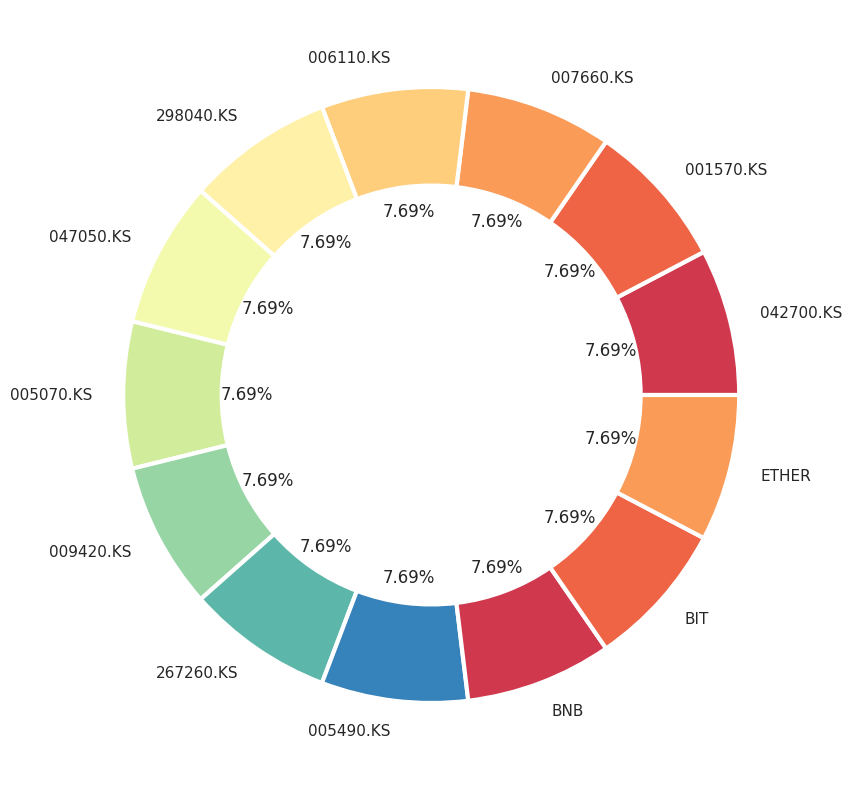

In [153]:
tickers2=['042700.KS',
 '001570.KS',
 '007660.KS',
 '006110.KS',
 '298040.KS',
 '047050.KS',
 '005070.KS',
 '009420.KS',
 '267260.KS',
 '005490.KS','BNB','BIT','ETHER']

# 파이차트 시각화
plt.figure(figsize=(10, 10))
wedgeprops = {'width': 0.32, 'edgecolor': 'w', 'linewidth': 3}
plt.pie(weights, labels=tickers2, autopct='%.2f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

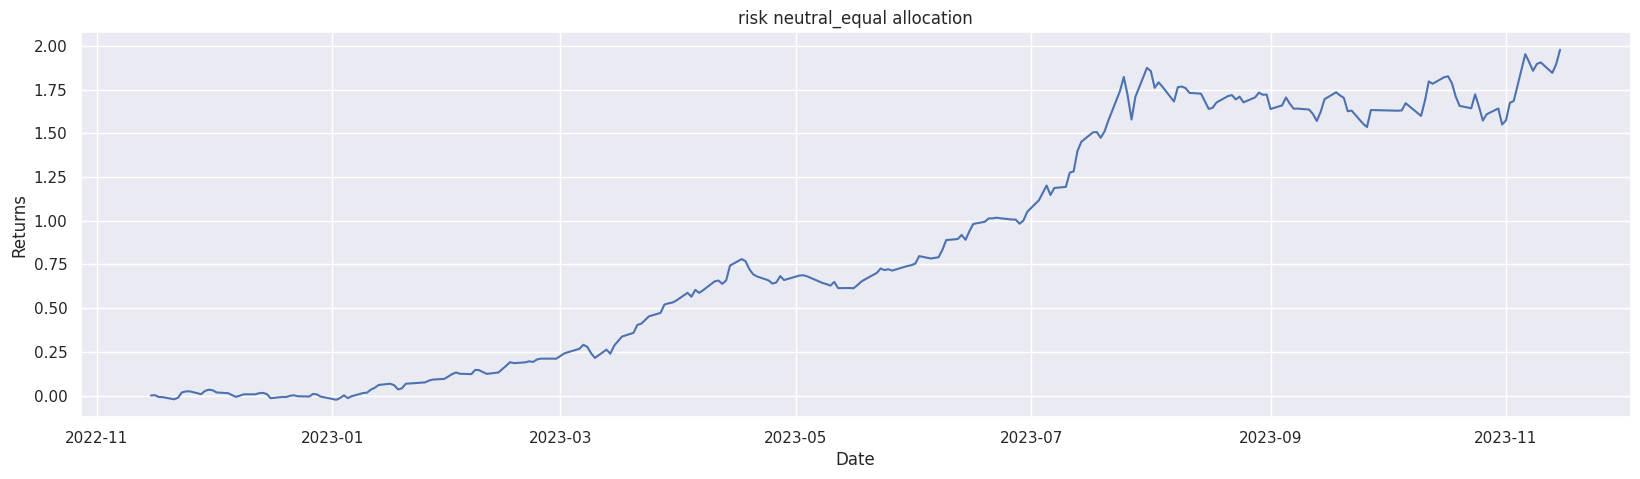

In [155]:
# 시계열 가중치 데이터프레임
ew_w_df = pd.DataFrame(get_ew_weights(rets), index=rets.index, columns=rets.columns)

# 동일 비중 포트폴리오 수익률
ew_port_rets = ew_w_df.shift() * rets

# 포트폴리오 누적 수익률
ew_port_cum_rets = (1 + ew_port_rets.sum(axis=1)).cumprod() - 1

# 그래프 결과
plt.figure(figsize=(20, 5))
plt.plot(ew_port_cum_rets)
plt.title('risk neutral_equal allocation')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

## 샤프비율 최대화

In [156]:
# 초기값 설정
noa = rets.shape[1]  # noa는 주어진 데이터(rets)의 열의 수를 나타냅니다. 이는 투자 대상 자산의 수입니다.
init_guess = np.repeat(1/noa, noa)  # init_guess는 초기 가중치를 동일하게 설정합니다. 각 자산에 동일한 비율로 투자합니다.

# 기대수익률 벡터
er = rets.mean() * 12  # er는 각 자산의 연간 기대수익률을 계산합니다.

# 공분산행렬
cov = rets.cov() * 12  # cov는 각 자산 간의 연간 공분산 행렬을 계산합니다.

# 각 ETF별 투자 가중치 상하한선 : 공매도 불가 조건
bounds = ((0.0, 1.0), ) * noa  # bounds는 각 자산의 투자 가중치의 상하한을 설정합니다. 여기서는 0과 1 사이로 설정하여 공매도를 금지합니다.

# 제약조건 : 전체 가중치의 합이 1, 레버리지 불가 조건
weights_sum_to_1 = {'type': 'eq',
                    'fun': lambda weights: np.sum(weights) - 1}  # weights_sum_to_1은 투자 가중치의 합이 1이 되도록 하는 제약조건입니다.

# 목적함수 : 마이너스 샤프비율
def neg_sharpe(weights, er, cov):  # neg_sharpe는 마이너스 샤프 비율을 계산하는 함수입니다.
    r = weights.T @ er  # r은 포트폴리오의 기대수익률입니다.
    vol = np.sqrt(weights.T @ cov @ weights)  # vol은 포트폴리오의 변동성입니다.
    return - r / vol  # 샤프 비율은 기대수익률을 변동성으로 나눈 값입니다. 여기서는 최대화 문제를 최소화 문제로 바꾸기 위해 음수를 취합니다.

# 최적화 알고리즘 구동
res = minimize(neg_sharpe,  # res는 최적화 알고리즘을 실행하여 얻은 결과입니다.
               init_guess,  # 초기 가중치로 init_guess를 사용합니다.
               args=(er, cov),  # 목적함수 neg_sharpe에 전달할 추가 인자입니다.
               method='SLSQP',  # 최적화 알고리즘으로 Sequential Least Squares Programming(SLSQP)을 사용합니다.
               constraints=(weights_sum_to_1,),  # 제약조건으로 weights_sum_to_1을 사용합니다.
               bounds=bounds)  # 각 자산의 투자 가중치의 상하한으로 bounds를 사용합니다.

# 가중치 결과값
weights = res.x  # weights는 최적화된 투자 가중치입니다.

# 결과 출력
print(weights)  # 최적화된 투자 가중치를 출력합니다.

[1.56704551e-02 3.81394778e-02 7.52161941e-17 8.13123486e-02
 7.81730750e-02 1.25262857e-01 1.39502390e-01 6.53387010e-02
 1.06698010e-01 5.80537777e-02 8.14074227e-17 1.38214335e-17
 2.91848909e-01]


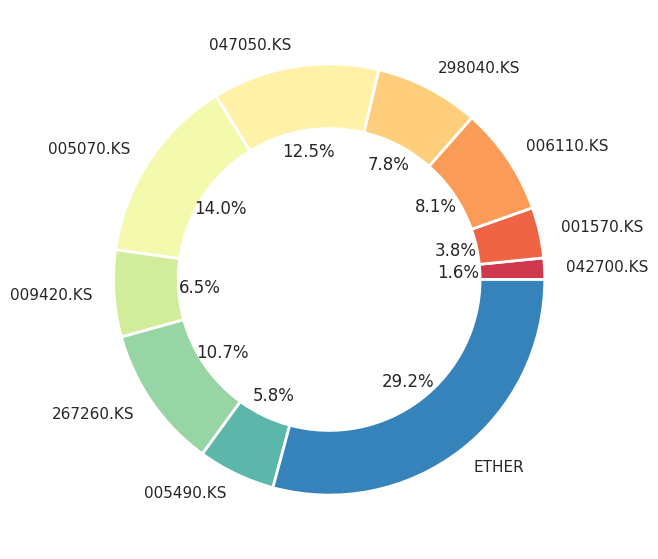

In [158]:
# 가중치 데이터프레임 생성
weights_df = pd.Series(np.round(weights, 3), index=tickers2)
weights_df = weights_df[weights_df > 0.0]

# 파이차트 시각화
plt.figure(figsize=(7, 7))
wedgeprops = {'width':0.3, 'edgecolor':'w', 'linewidth':2}
plt.pie(weights_df, labels=weights_df.index, autopct='%.1f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

In [159]:
# MSR 모델 가중치 계산 함수
def get_msr_weights(er, cov):

    # 자산 개수
    noa = er.shape[0]

    # 초기 가중치
    init_guess = np.repeat(1/noa, noa)

    # 제약조건 및 상하한값
    bounds = ((0.0, 1.0), ) * noa
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1}

    # 목적함수: 마이너스 샤프비율
    def neg_sharpe(weights, er, cov):
        r = weights.T @ er
        vol = np.sqrt(weights.T @ cov @ weights)
        return - r / vol

    # 최적화 수행
    res = minimize(neg_sharpe,
                   init_guess,
                   args=(er, cov),
                   method='SLSQP',
                   constraints=(weights_sum_to_1,),
                   bounds=bounds)

    return res.x

In [160]:
# 빈 데이터프레임 생성
msr_w_df = pd.DataFrame().reindex_like(rets)

# 기대수익률 배열
er = np.array(rets * 12)

# 공분산행렬 배열
cov = rets.rolling(12).cov().fillna(0) * 12
cov = cov.values.reshape(int(cov.shape[0] / cov.shape[1]), cov.shape[1], cov.shape[1])

for i in range(12, len(msr_w_df)):
    msr_w_df.iloc[i] = get_msr_weights(er[i-1], cov[i-1])

In [161]:
msr_w_df

,001570.KS,005070.KS,005490.KS,006110.KS,007660.KS,009420.KS,042700.KS,047050.KS,267260.KS,298040.KS,bnb,ether,bit
Date,,,,,,,,,,,,,
2022-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.307069,0.000000e+00,0.000000e+00,0.692931,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2023-11-10,1.546884e-14,2.311657e-15,1.116891e-14,0.013151,0.000000e+00,0.000000,9.035724e-02,8.600682e-16,0.146274,1.882108e-15,1.711662e-15,7.502186e-01,0.000000e+00
2023-11-13,0.000000e+00,0.000000e+00,0.000000e+00,0.073792,0.000000e+00,0.000000,1.901940e-01,0.000000e+00,0.127914,4.614210e-12,3.325619e-13,2.036214e-13,6.080997e-01


Text(0, 0.5, 'Returns')

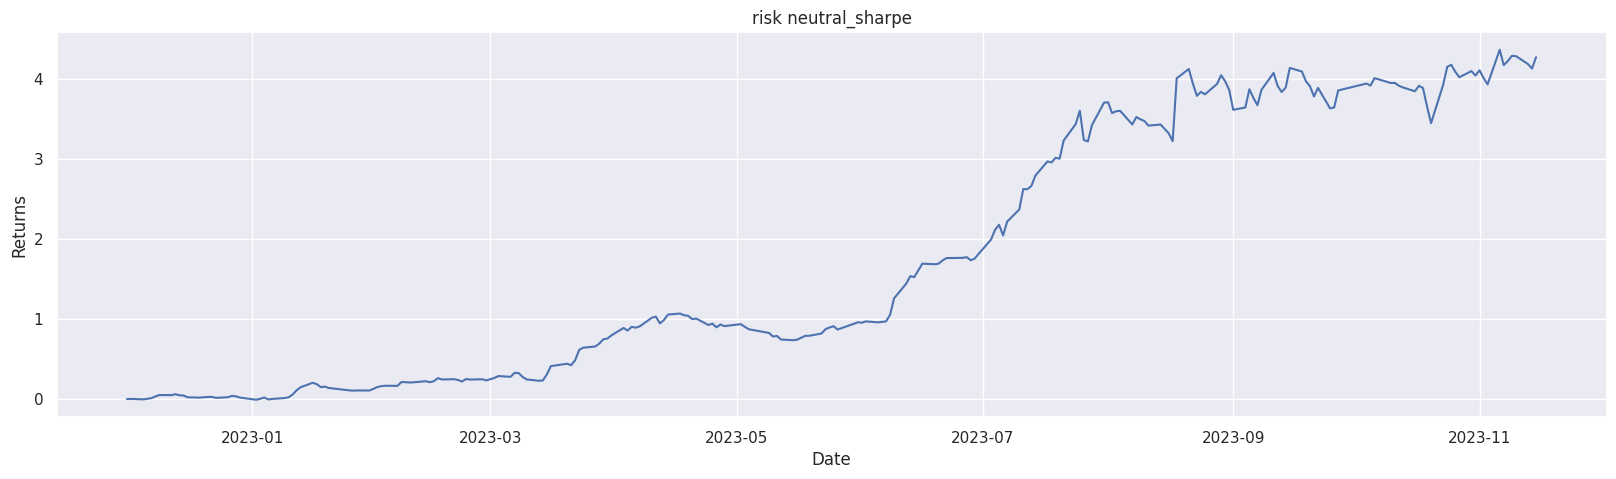

In [162]:
# 포트폴리오 수익률 데이터프레임
msr_port_rets = msr_w_df.shift() * rets
msr_port_cum_rets = (1 + msr_port_rets.sum(axis=1)).cumprod() - 1

# MSR 백테스팅 시각화
plt.figure(figsize=(20, 5))
plt.plot(msr_port_cum_rets.iloc[12:])
plt.title('risk neutral_sharpe')
plt.xlabel('Date')
plt.ylabel('Returns')

# 위험회피군 포트폴리오 최적화

## 동일비중

In [164]:
# 포트폴리오 데이터 다운로드
tickers = ['137310.KS','011200.KS','042700.KS','000990.KS','108320.KS','005930.KS','111770.KS','180640.KS','383220.KS','011780.KS']
ptf = yf.Tickers(tickers)
data3 = ptf.history(interval='1d' ,start='2022-11-15',end='2023-11-16', actions=False)
data3.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data3 = data3.droplevel(0, axis=1)

[*********************100%%**********************]  10 of 10 completed


In [ ]:
xrp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y-FoRM/장기프로젝트/암호화폐 자료/XRP 과거 데이터.csv')
bnb = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y-FoRM/장기프로젝트/암호화폐 자료/BNB 과거 데이터.csv')
tet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y-FoRM/장기프로젝트/암호화폐 자료/Tether 과거 데이터.csv')
ether = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y-FoRM/장기프로젝트/암호화폐 자료/이더리움 과거 데이터.csv')
bit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y-FoRM/장기프로젝트/암호화폐 자료/비트코인 과거 데이터.csv',thousands=',')

In [ ]:
bit.drop(['시가', '고가', '저가', '거래량','변동 %'], inplace=True, axis=1)
bit.sort_values(by='날짜',inplace=True)
bit.columns = ['Date','BTC']
bit

,Date,BTC
365,2022-11-15,16895.1
364,2022-11-16,16540.5
363,2022-11-17,16691.2
362,2022-11-18,16638.3
361,2022-11-19,16699.2
...,...,...
4,2023-11-11,37150.5
3,2023-11-12,37064.4
2,2023-11-13,36478.3
1,2023-11-14,35549.3


In [165]:
data3

,000990.KS,005930.KS,011200.KS,011780.KS,042700.KS,108320.KS,111770.KS,137310.KS,180640.KS,383220.KS
Date,,,,,,,,,,
2022-11-15,47372.925781,61349.085938,20413.730469,148164.218750,12836.938477,89528.296875,47032.503906,34832.941406,40823.097656,156774.828125
2022-11-16,47517.945312,61644.031250,19846.681641,143353.687500,12935.305664,89811.320312,47274.687500,33841.960938,41221.371094,154796.593750
2022-11-17,46406.128906,60365.929688,19421.396484,142391.578125,12689.387695,89056.601562,46402.820312,34634.742188,40872.878906,154302.046875
2022-11-18,46502.808594,60759.191406,19279.634766,141429.468750,12787.754883,90000.000000,47468.437500,34783.390625,40375.039062,157269.390625
2022-11-21,45632.695312,60365.929688,19137.871094,140948.421875,12886.122070,86226.414062,48437.179688,32206.843750,40126.117188,149356.468750
...,...,...,...,...,...,...,...,...,...,...
2023-11-09,55300.000000,70300.000000,16390.000000,130800.000000,61500.000000,88200.000000,55600.000000,11370.000000,47950.000000,94100.000000
2023-11-10,54200.000000,70500.000000,16550.000000,129000.000000,66300.000000,87200.000000,54700.000000,11150.000000,47450.000000,92000.000000
2023-11-13,53900.000000,70400.000000,16370.000000,126200.000000,57800.000000,92000.000000,54300.000000,11000.000000,48000.000000,90100.000000


In [ ]:
bit['Date']=bit['Date'].astype('datetime64')
data=data.reset_index()
data=pd.merge(data,bit)
data.set_index('Date',inplace=True)
data

,000990.KS,005930.KS,011200.KS,011780.KS,042700.KS,108320.KS,111770.KS,137310.KS,180640.KS,383220.KS,BTC
Date,,,,,,,,,,,
2022-11-15,47372.925781,61349.085938,20413.730469,148164.218750,12836.938477,89528.296875,47032.503906,34832.941406,40823.097656,156774.828125,16895.1
2022-11-16,47517.945312,61644.035156,19846.681641,143353.687500,12935.305664,89811.320312,47274.687500,33841.960938,41221.371094,154796.593750,16540.5
2022-11-17,46406.128906,60365.925781,19421.396484,142391.578125,12689.387695,89056.601562,46402.820312,34634.742188,40872.878906,154302.046875,16691.2
2022-11-18,46502.808594,60759.191406,19279.634766,141429.468750,12787.754883,90000.000000,47468.437500,34783.390625,40375.039062,157269.390625,16638.3
2022-11-21,45632.695312,60365.925781,19137.871094,140948.421875,12886.122070,86226.414062,48437.179688,32206.843750,40126.117188,149356.468750,15776.2
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,55300.000000,70300.000000,16390.000000,130800.000000,61500.000000,88200.000000,55600.000000,11370.000000,47950.000000,94100.000000,36700.5
2023-11-10,54200.000000,70500.000000,16550.000000,129000.000000,66300.000000,87200.000000,54700.000000,11150.000000,47450.000000,92000.000000,37303.0
2023-11-13,53900.000000,70400.000000,16370.000000,126200.000000,57800.000000,92000.000000,54300.000000,11000.000000,48000.000000,90100.000000,36478.3


In [166]:
rets = data3.pct_change().fillna(0)
rets

,000990.KS,005930.KS,011200.KS,011780.KS,042700.KS,108320.KS,111770.KS,137310.KS,180640.KS,383220.KS
Date,,,,,,,,,,
2022-11-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-11-16,0.003061,0.004808,-0.027778,-0.032468,0.007663,0.003161,0.005149,-0.028450,0.009756,-0.012618
2022-11-17,-0.023398,-0.020734,-0.021429,-0.006711,-0.019011,-0.008403,-0.018443,0.023426,-0.008454,-0.003195
2022-11-18,0.002083,0.006515,-0.007299,-0.006757,0.007752,0.010593,0.022964,0.004292,-0.012180,0.019231
2022-11-21,-0.018711,-0.006472,-0.007353,-0.003401,0.007692,-0.041929,0.020408,-0.074074,-0.006165,-0.050314
...,...,...,...,...,...,...,...,...,...,...
2023-11-09,0.012821,0.005722,-0.000610,0.010039,0.011513,0.109434,0.061069,-0.024034,0.022388,-0.001062
2023-11-10,-0.019892,0.002845,0.009762,-0.013761,0.078049,-0.011338,-0.016187,-0.019349,-0.010428,-0.022317
2023-11-13,-0.005535,-0.001418,-0.010876,-0.021705,-0.128205,0.055046,-0.007313,-0.013453,0.011591,-0.020652


In [167]:
# 가중치 계산 함수
def get_ew_weights(rets):
    noa = len(rets.columns)
    weights = np.ones_like(rets) * (1/noa)
    return weights

# 동일 가중치
weights = get_ew_weights(rets)[-1]

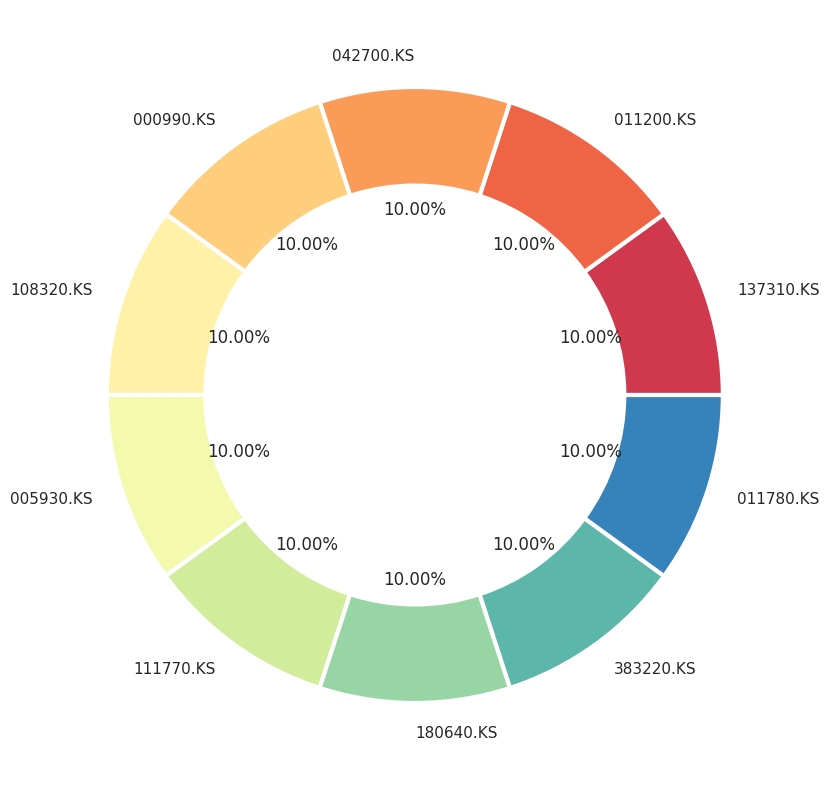

In [168]:


# 파이차트 시각화
plt.figure(figsize=(10, 10))
wedgeprops = {'width': 0.32, 'edgecolor': 'w', 'linewidth': 3}
plt.pie(weights, labels=tickers, autopct='%.2f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

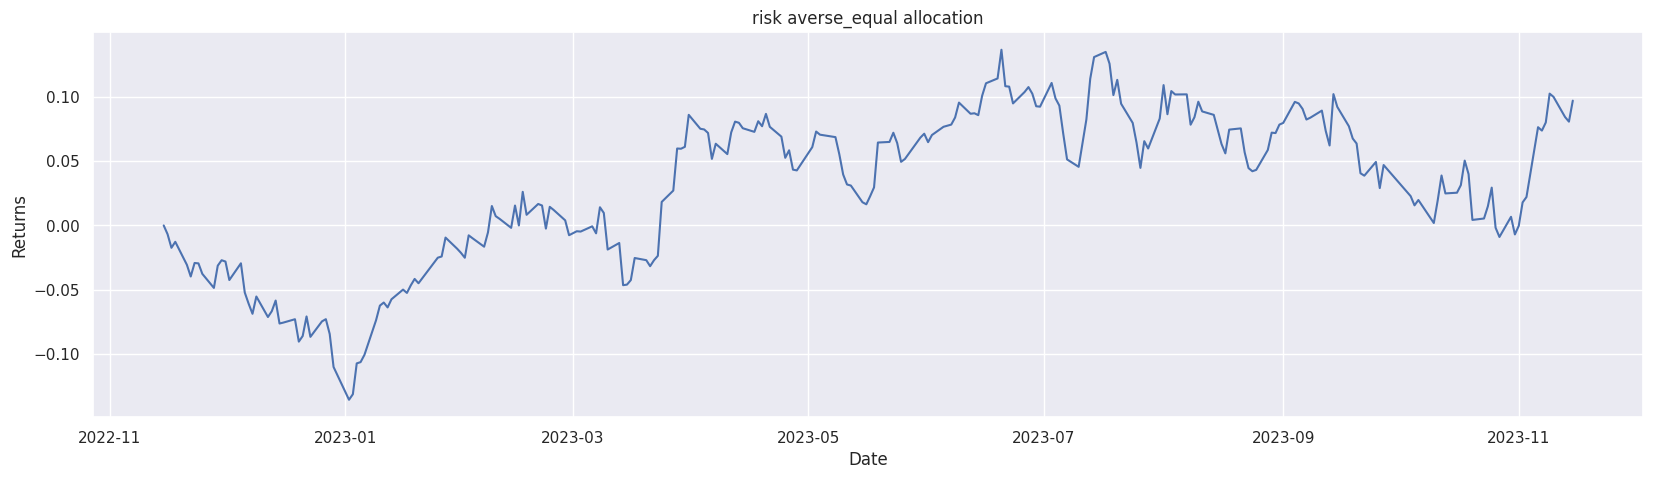

In [169]:
# 시계열 가중치 데이터프레임
ew_w_df = pd.DataFrame(get_ew_weights(rets), index=rets.index, columns=rets.columns)

# 동일 비중 포트폴리오 수익률
ew_port_rets = ew_w_df.shift() * rets

# 포트폴리오 누적 수익률
ew_port_cum_rets = (1 + ew_port_rets.sum(axis=1)).cumprod() - 1

# 그래프 결과
plt.figure(figsize=(20, 5))
plt.plot(ew_port_cum_rets)
plt.title('risk averse_equal allocation')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

## 샤프비율 최대화

In [170]:
# 초기값 설정
noa = rets.shape[1]  # noa는 주어진 데이터(rets)의 열의 수를 나타냅니다. 이는 투자 대상 자산의 수입니다.
init_guess = np.repeat(1/noa, noa)  # init_guess는 초기 가중치를 동일하게 설정합니다. 각 자산에 동일한 비율로 투자합니다.

# 기대수익률 벡터
er = rets.mean() * 12  # er는 각 자산의 연간 기대수익률을 계산합니다.

# 공분산행렬
cov = rets.cov() * 12  # cov는 각 자산 간의 연간 공분산 행렬을 계산합니다.

# 각 ETF별 투자 가중치 상하한선 : 공매도 불가 조건
bounds = ((0.0, 1.0), ) * noa  # bounds는 각 자산의 투자 가중치의 상하한을 설정합니다. 여기서는 0과 1 사이로 설정하여 공매도를 금지합니다.

# 제약조건 : 전체 가중치의 합이 1, 레버리지 불가 조건
weights_sum_to_1 = {'type': 'eq',
                    'fun': lambda weights: np.sum(weights) - 1}  # weights_sum_to_1은 투자 가중치의 합이 1이 되도록 하는 제약조건입니다.

# 목적함수 : 마이너스 샤프비율
def neg_sharpe(weights, er, cov):  # neg_sharpe는 마이너스 샤프 비율을 계산하는 함수입니다.
    r = weights.T @ er  # r은 포트폴리오의 기대수익률입니다.
    vol = np.sqrt(weights.T @ cov @ weights)  # vol은 포트폴리오의 변동성입니다.
    return - r / vol  # 샤프 비율은 기대수익률을 변동성으로 나눈 값입니다. 여기서는 최대화 문제를 최소화 문제로 바꾸기 위해 음수를 취합니다.

# 최적화 알고리즘 구동
res = minimize(neg_sharpe,  # res는 최적화 알고리즘을 실행하여 얻은 결과입니다.
               init_guess,  # 초기 가중치로 init_guess를 사용합니다.
               args=(er, cov),  # 목적함수 neg_sharpe에 전달할 추가 인자입니다.
               method='SLSQP',  # 최적화 알고리즘으로 Sequential Least Squares Programming(SLSQP)을 사용합니다.
               constraints=(weights_sum_to_1,),  # 제약조건으로 weights_sum_to_1을 사용합니다.
               bounds=bounds)  # 각 자산의 투자 가중치의 상하한으로 bounds를 사용합니다.

# 가중치 결과값
weights = res.x  # weights는 최적화된 투자 가중치입니다.

# 결과 출력
print(weights)  # 최적화된 투자 가중치를 출력합니다.

[0.00000000e+00 1.24807461e-04 0.00000000e+00 1.30308651e-17
 5.99235440e-01 0.00000000e+00 2.84939596e-01 2.20911223e-16
 1.15700157e-01 1.57419045e-17]


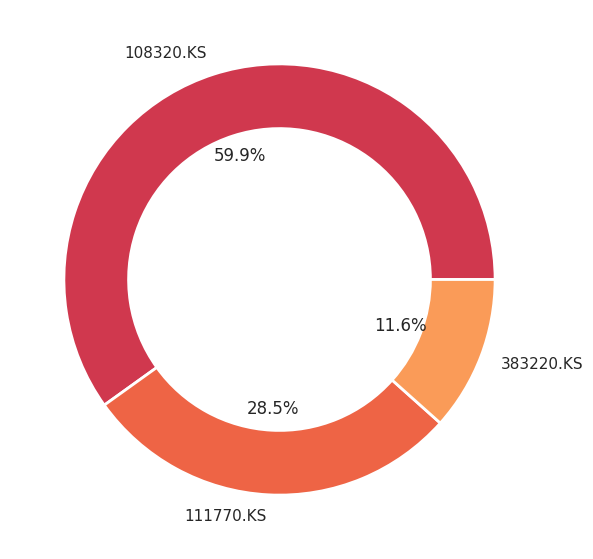

In [171]:
# 가중치 데이터프레임 생성
weights_df = pd.Series(np.round(weights, 3), index=tickers)
weights_df = weights_df[weights_df > 0.0]

# 파이차트 시각화
plt.figure(figsize=(7, 7))
wedgeprops = {'width':0.3, 'edgecolor':'w', 'linewidth':2}
plt.pie(weights_df, labels=weights_df.index, autopct='%.1f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

In [173]:
# MSR 모델 가중치 계산 함수
def get_msr_weights(er, cov):

    # 자산 개수
    noa = er.shape[0]

    # 초기 가중치
    init_guess = np.repeat(1/noa, noa)

    # 제약조건 및 상하한값
    bounds = ((0.0, 1.0), ) * noa
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1}

    # 목적함수: 마이너스 샤프비율
    def neg_sharpe(weights, er, cov):
        r = weights.T @ er
        vol = np.sqrt(weights.T @ cov @ weights)
        return - r / vol

    # 최적화 수행
    res = minimize(neg_sharpe,
                   init_guess,
                   args=(er, cov),
                   method='SLSQP',
                   constraints=(weights_sum_to_1,),
                   bounds=bounds)

    return res.x

In [175]:
# 빈 데이터프레임 생성
msr_w_df = pd.DataFrame().reindex_like(rets)

# 기대수익률 배열
er = np.array(rets * 12)

# 공분산행렬 배열
cov = rets.rolling(12).cov().fillna(0) * 12
cov = cov.values.reshape(int(cov.shape[0] / cov.shape[1]), cov.shape[1], cov.shape[1])

for i in range(12, len(msr_w_df)):
    msr_w_df.iloc[i] = get_msr_weights(er[i-1], cov[i-1])

In [176]:
msr_w_df

,000990.KS,005930.KS,011200.KS,011780.KS,042700.KS,108320.KS,111770.KS,137310.KS,180640.KS,383220.KS
Date,,,,,,,,,,
2022-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-11-09,8.966270e-16,0.000000e+00,0.088855,1.745945e-15,0.000000e+00,1.464740e-16,1.158309e-15,9.111447e-01,9.341970e-16,3.077900e-17
2023-11-10,1.003708e-15,5.560555e-16,0.000000,0.000000e+00,6.043360e-16,6.551479e-01,3.448521e-01,0.000000e+00,9.368420e-16,6.887027e-16
2023-11-13,0.000000e+00,8.913420e-15,0.079450,0.000000e+00,7.076792e-01,0.000000e+00,2.128712e-01,0.000000e+00,5.536796e-15,0.000000e+00


Text(0, 0.5, 'Returns')

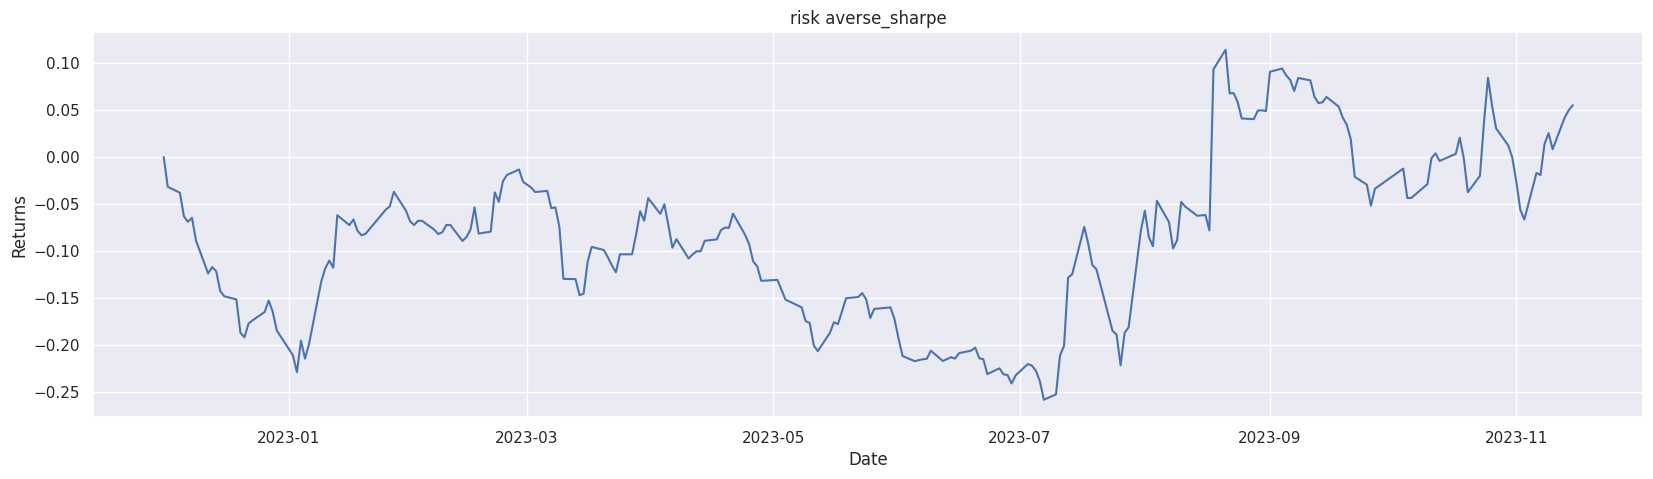

In [177]:
# 포트폴리오 수익률 데이터프레임
msr_port_rets = msr_w_df.shift() * rets
msr_port_cum_rets = (1 + msr_port_rets.sum(axis=1)).cumprod() - 1

# MSR 백테스팅 시각화
plt.figure(figsize=(20, 5))
plt.plot(msr_port_cum_rets.iloc[12:])
plt.title('risk averse_sharpe')
plt.xlabel('Date')
plt.ylabel('Returns')